# Modeling par classification

Objectif : entraîner et comparer quelques modèles de classification sur les données prétraitées (`data/processed/train.csv` et `test.csv`).

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
RANDOM_STATE = 42

In [13]:
# Chargement des jeux train/test prétraités
train_path = Path('..') / 'data' / 'processed' / 'train.csv'
test_path = Path('..') / 'data' / 'processed' / 'test.csv'

for p in [train_path, test_path]:
    assert p.exists(), f"Fichier manquant : {p}"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# La première colonne est un index sauvegardé par pandas, on la drop
to_drop = [col for col in train_df.columns if col.startswith('Unnamed') or col == '']
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

train_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,exam passed,language passed,math passed
0,0,5,4,0,1,1,1,1
1,1,3,0,0,1,1,1,0
2,0,4,2,1,0,1,1,1
3,0,0,2,0,0,1,1,1
4,1,4,2,1,1,1,1,1


In [14]:
# Séparation features / cible
target_col = ["language passed", "math passed","exam passed"]

# Colonnes socio-démo communes
base_cols = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course",
]

# Definitions des feature et des targets
tasks = {
    "language": {
        "target": "language passed",
        "features": base_cols 
    },
    "math": {
        "target": "math passed",
        "features": base_cols,
    },
    "exam": {
        "target": "exam passed",
        "features": base_cols,
    },
}

In [15]:
# Split train/validation pour chaque tâche
from collections import OrderedDict

data_splits = OrderedDict()
for task_name, spec in tasks.items():
    feat_cols = spec["features"]
    target = spec["target"]

    X_full = train_df[feat_cols]
    y_full = train_df[target]
    X_test_holdout = test_df[feat_cols]
    y_test_holdout = test_df[target]

    X_train, X_val, y_train, y_val = train_test_split(
        X_full, y_full, test_size=0.2, stratify=y_full, random_state=RANDOM_STATE
    )

    data_splits[task_name] = {
        "X_train": X_train,
        "X_val": X_val,
        "y_train": y_train,
        "y_val": y_val,
        "X_test": X_test_holdout,
        "y_test": y_test_holdout,
    }

    print(f"Tâche: {task_name} -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test_holdout.shape}")

Tâche: language -> Train: (640, 5), Val: (160, 5), Test: (200, 5)
Tâche: math -> Train: (640, 5), Val: (160, 5), Test: (200, 5)
Tâche: exam -> Train: (640, 5), Val: (160, 5), Test: (200, 5)


In [16]:
# Helper d'entraînement + évaluation

def fit_eval(model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    proba = model.predict_proba(X_va)[:, 1] if hasattr(model, "predict_proba") else None
    return {
        "accuracy": accuracy_score(y_va, preds),
        "f1": f1_score(y_va, preds),
        "roc_auc": roc_auc_score(y_va, proba) if proba is not None else np.nan,
        "model": model,
    }

# Modèles à comparer (ajout XGBoost, LightGBM, SVM linéaire calibré)
models = {
    "log_reg": LogisticRegression(max_iter=1000, n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=400, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"),
    "gboost": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "xgb": XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "lgbm": LGBMClassifier(
        n_estimators=400,
        max_depth=-1,
        num_leaves=31,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
    ),
    "linear_svm": CalibratedClassifierCV(
        cv=3,
        n_jobs=-1,
    ),
}

from sklearn.base import clone

# Évalue chaque modèle pour chaque tâche
results = {}
for task_name, split in data_splits.items():
    results[task_name] = {}
    for name, model in models.items():
        clf = clone(model)
        res = fit_eval(clf, split["X_train"], split["y_train"], split["X_val"], split["y_val"])
        results[task_name][name] = res

rows = []
for task_name, model_res in results.items():
    for name, res in model_res.items():
        rows.append(
            {
                "target_task": task_name,
                "model": name,
                "accuracy": res["accuracy"],
                "f1": res["f1"],
                "roc_auc": res["roc_auc"],
            }
        )

df_res = pd.DataFrame(rows).sort_values(["target_task", "f1"], ascending=[True, False])
df_res

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 471, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.735938 -> initscore=1.024959
[LightGBM] [Info] Start training from score 1.024959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 471, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.735938 -> initscore=1.024959
[LightGBM] [Info] Start training from score 1.024959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,target_task,model,accuracy,f1,roc_auc
17,exam,linear_svm,0.74375,0.837945,0.764541
15,exam,xgb,0.73125,0.827309,0.670048
16,exam,lgbm,0.71875,0.820717,0.659614
14,exam,gboost,0.70000,0.804878,0.688213
13,exam,rf,0.65625,0.746544,0.636812
12,exam,log_reg,0.66875,0.736318,0.762802
5,language,linear_svm,0.75000,0.842520,0.754843
3,language,xgb,0.75000,0.838710,0.706215
2,language,gboost,0.73750,0.832000,0.727300
4,language,lgbm,0.73125,0.823045,0.713075


In [17]:
# Sélection du meilleur modèle sur la validation pour chaque tâche
best_by_task = {}
for task_name, model_res in results.items():
    best_name = max(model_res, key=lambda name: model_res[name]["f1"])
    best_by_task[task_name] = {
        "model_name": best_name,
        "model": model_res[best_name]["model"],
        "val_accuracy": model_res[best_name]["accuracy"],
        "val_f1": model_res[best_name]["f1"],
        "val_roc_auc": model_res[best_name]["roc_auc"],
    }

best_summary = pd.DataFrame(
    [
        {
            "target_task": task_name,
            "best_model": info["model_name"],
            "val_accuracy": info["val_accuracy"],
            "val_f1": info["val_f1"],
            "val_roc_auc": info["val_roc_auc"],
        }
        for task_name, info in best_by_task.items()
    ]
).sort_values("target_task")

print("Scores validation (triés par F1 par tâche):")
display(df_res)
print("\nMeilleurs modèles par tâche:")
display(best_summary)

Scores validation (triés par F1 par tâche):


Scores validation (triés par F1 par tâche):


,target_task,model,accuracy,f1,roc_auc
17,exam,linear_svm,0.74375,0.837945,0.764541
15,exam,xgb,0.73125,0.827309,0.670048
16,exam,lgbm,0.71875,0.820717,0.659614
14,exam,gboost,0.70000,0.804878,0.688213
13,exam,rf,0.65625,0.746544,0.636812
12,exam,log_reg,0.66875,0.736318,0.762802
5,language,linear_svm,0.75000,0.842520,0.754843
3,language,xgb,0.75000,0.838710,0.706215
2,language,gboost,0.73750,0.832000,0.727300
4,language,lgbm,0.73125,0.823045,0.713075



Meilleurs modèles par tâche:


Scores validation (triés par F1 par tâche):


,target_task,model,accuracy,f1,roc_auc
17,exam,linear_svm,0.74375,0.837945,0.764541
15,exam,xgb,0.73125,0.827309,0.670048
16,exam,lgbm,0.71875,0.820717,0.659614
14,exam,gboost,0.70000,0.804878,0.688213
13,exam,rf,0.65625,0.746544,0.636812
12,exam,log_reg,0.66875,0.736318,0.762802
5,language,linear_svm,0.75000,0.842520,0.754843
3,language,xgb,0.75000,0.838710,0.706215
2,language,gboost,0.73750,0.832000,0.727300
4,language,lgbm,0.73125,0.823045,0.713075



Meilleurs modèles par tâche:


,target_task,best_model,val_accuracy,val_f1,val_roc_auc
2,exam,linear_svm,0.74375,0.837945,0.764541
0,language,linear_svm,0.75000,0.842520,0.754843
1,math,linear_svm,0.70000,0.803279,0.705929


In [18]:
# Sauvegarde des deux meilleurs modèles pour la tâche "exam"
exam_top2 = (
    df_res[df_res["target_task"] == "exam"]
    .sort_values("f1", ascending=False)
    .head(2)
)

models_dir = Path("..") / "models"
models_dir.mkdir(parents=True, exist_ok=True)

saved_models = []
for _, row in exam_top2.iterrows():
    model_name = row["model"]
    fitted_model = results["exam"][model_name]["model"]
    out_path = models_dir / f"exam_{model_name}.joblib"
    joblib.dump(fitted_model, out_path)
    saved_models.append({"model": model_name, "val_f1": row["f1"], "path": out_path})

print("Modèles exam sauvegardés (top 2 validation F1):")
for item in saved_models:
    print(f"- {item['model']} (val_f1={item['val_f1']:.3f}) -> {item['path']}")

Modèles exam sauvegardés (top 2 validation F1):
- linear_svm (val_f1=0.838) -> ..\models\exam_linear_svm.joblib
- xgb (val_f1=0.827) -> ..\models\exam_xgb.joblib


In [19]:
# Évaluation sur le jeu de test tenu à part pour le meilleur modèle de chaque tâche
test_results = []
test_outputs = {}

for task_name, info in best_by_task.items():
    split = data_splits[task_name]
    model = info["model"]
    test_preds = model.predict(split["X_test"])
    test_proba = model.predict_proba(split["X_test"])[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "target_task": task_name,
        "model": info["model_name"],
        "accuracy": accuracy_score(split["y_test"], test_preds),
        "f1": f1_score(split["y_test"], test_preds),
        "roc_auc": roc_auc_score(split["y_test"], test_proba) if test_proba is not None else np.nan,
    }
    test_results.append(metrics)
    test_outputs[task_name] = {"y_true": split["y_test"], "preds": test_preds, "proba": test_proba}

    print(f"Rapport de classification ({task_name}):")
    print(classification_report(split["y_test"], test_preds, target_names=["fail", "pass"]))

print("\nScores sur test (meilleur modèle par tâche):")
test_results_df = pd.DataFrame(test_results).sort_values("target_task")
display(test_results_df)

Rapport de classification (language):
              precision    recall  f1-score   support

        fail       0.46      0.23      0.31        52
        pass       0.77      0.91      0.83       148

    accuracy                           0.73       200
   macro avg       0.62      0.57      0.57       200
weighted avg       0.69      0.73      0.70       200

Rapport de classification (math):
              precision    recall  f1-score   support

        fail       0.55      0.39      0.45        62
        pass       0.76      0.86      0.80       138

    accuracy                           0.71       200
   macro avg       0.65      0.62      0.63       200
weighted avg       0.69      0.71      0.69       200

Rapport de classification (exam):
              precision    recall  f1-score   support

        fail       0.47      0.31      0.37        55
        pass       0.77      0.87      0.82       145

    accuracy                           0.71       200
   macro avg       0.6

,target_task,model,accuracy,f1,roc_auc
2,exam,linear_svm,0.715,0.815534,0.702132
0,language,linear_svm,0.730,0.832298,0.746167
1,math,linear_svm,0.710,0.802721,0.718911


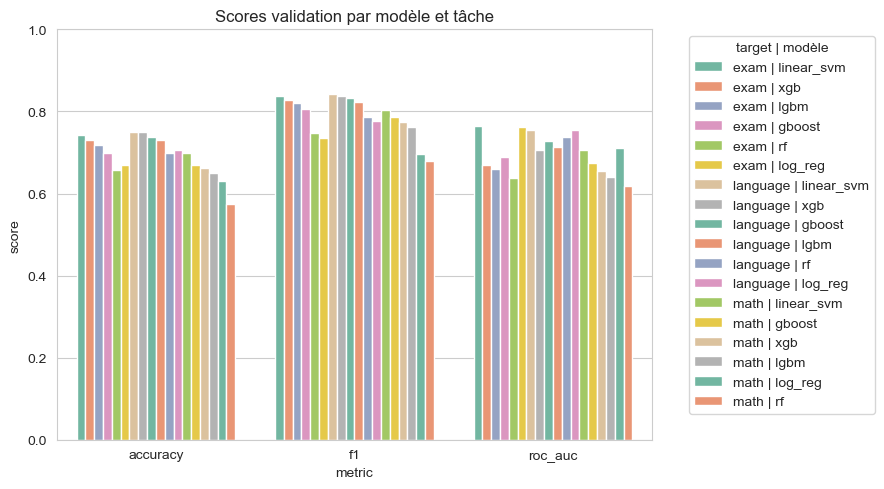

In [20]:
# Visualisation des métriques validation (accuracy / f1 / roc_auc)
plot_df = df_res.melt(id_vars=["target_task", "model"], value_vars=["accuracy", "f1", "roc_auc"], var_name="metric", value_name="score")
plot_df["label"] = plot_df["target_task"] + " | " + plot_df["model"]

plt.figure(figsize=(9, 5))
sns.barplot(data=plot_df, x="metric", y="score", hue="label", palette="Set2")
plt.title("Scores validation par modèle et tâche")
plt.ylim(0, 1)
plt.legend(title="target | modèle", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

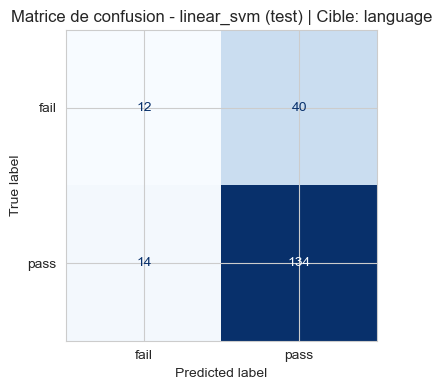

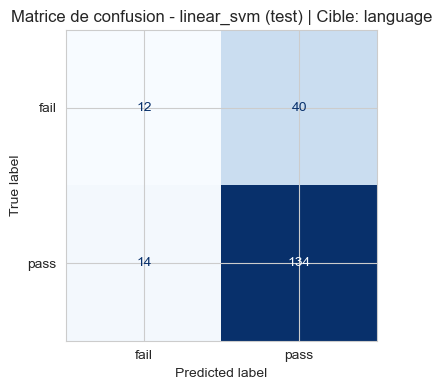

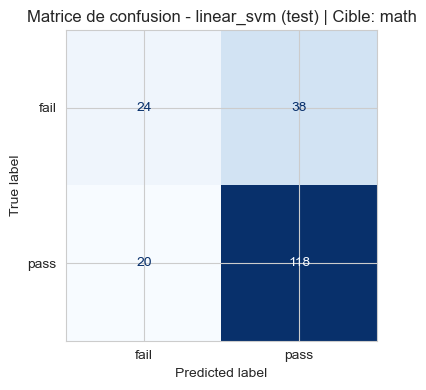

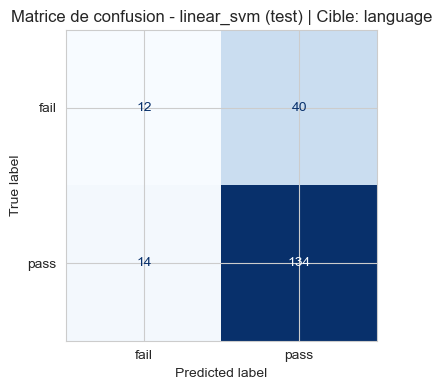

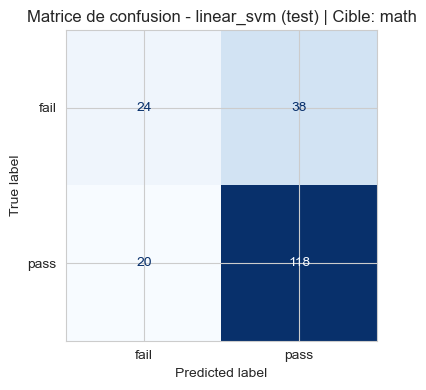

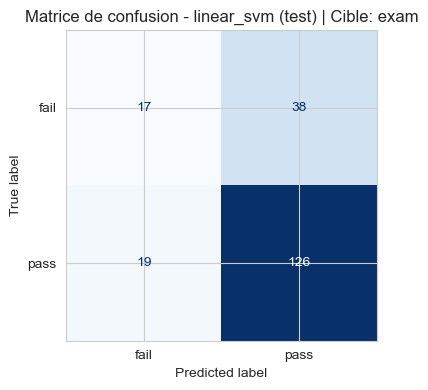

In [21]:
# Matrice de confusion sur le test pour le meilleur modèle de chaque tâche
from sklearn.metrics import ConfusionMatrixDisplay

for task_name, out in test_outputs.items():
    fig, ax = plt.subplots(figsize=(4, 4))
    ConfusionMatrixDisplay.from_predictions(
        out["y_true"],
        out["preds"],
        display_labels=["fail", "pass"],
        cmap="Blues",
        colorbar=False,
        ax=ax,
    )
    ax.set_title(f"Matrice de confusion - {best_by_task[task_name]['model_name']} (test) | Cible: {task_name}")
    plt.tight_layout()
    plt.show()

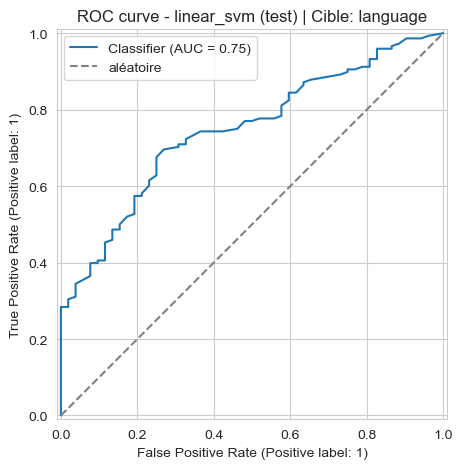

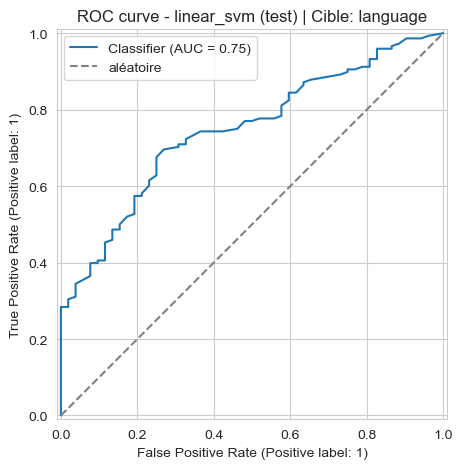

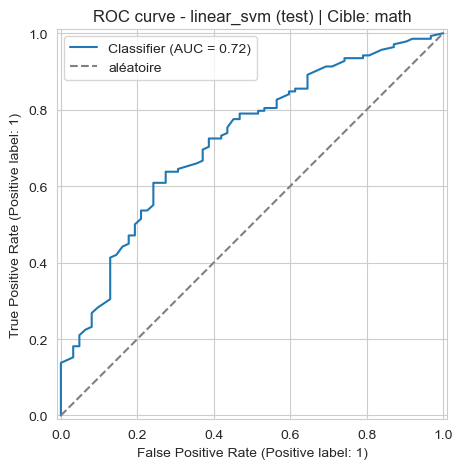

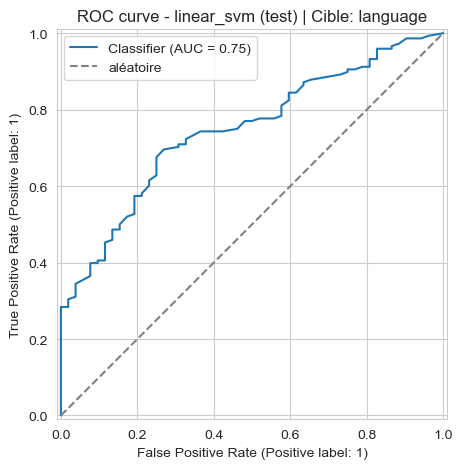

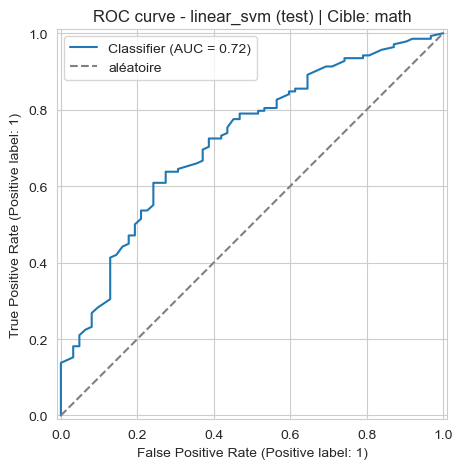

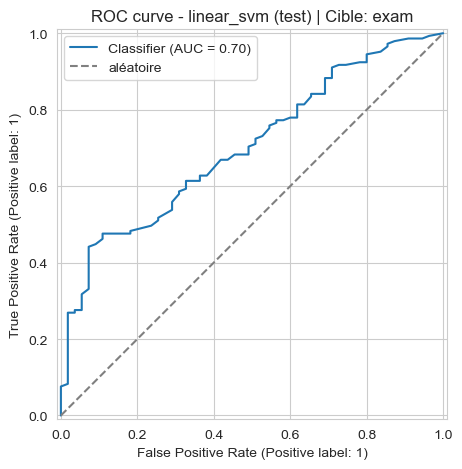

In [22]:
# Courbe ROC sur le test (si proba dispo)
from sklearn.metrics import RocCurveDisplay

for task_name, out in test_outputs.items():
    if out["proba"] is not None:
        RocCurveDisplay.from_predictions(out["y_true"], out["proba"])
        plt.title(f"ROC curve - {best_by_task[task_name]['model_name']} (test) | Cible: {task_name}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="aléatoire")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"Pas de predict_proba disponible pour {best_by_task[task_name]['model_name']} ({task_name}).")